### Notebook 5 - Comparison of parameter estimates from this work to published data

In this notebook, correlations between the parameter estimates derived here and three other datasets are explored. These datasets are
- protein lifetime data from Arike et al., Cell Reports 2020 (https://www.sciencedirect.com/science/article/pii/S2211124719317255)

- protein lifetime and translation rate data from Schwanhaeusser et al., Nature 2011 (https://www.nature.com/articles/nature10098?page=63)

- translation efficiency data derived via ribosome profiling by Moor et al., Science 2017 (https://science.sciencemag.org/content/357/6357/1299.abstract)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr, linregress
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# import custom functions
from MCMC_pipe import import_data

In [2]:
sns.set_context('talk')
sns.set_style('white')

#### A) Data import and preparation

In [3]:
# read mRNA and protein profiles
M_data, P_data, Psem_data, M_interp_dict, beta_gamma_dist, delta_gamma_dist = \
    import_data(import_folder='processed_data')
# rename columns for mrna, protein and sem to v1-v6
col_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']
M_data.columns = col_names
P_data.columns = col_names
Psem_data.columns = col_names
# read mean dataframe
mean_df = pd.read_csv('processed_data/P_and_M_means.csv', index_col=0)

In [4]:
# read MCMC parameter results and sort alphabetically
results_df = pd.read_csv('extracted_results/MCMC_result_collection.csv', index_col=0)
results_df.sort_index(inplace=True)

In [5]:
len(results_df)

2866

In [6]:
# add a columnd for half life in hours, build on mode
results_df['half life (hours)'] = np.log(2)/results_df['delta_mode']

In [7]:
mean_df.sort_index(axis=0, inplace=True)

In [8]:
# attach the mean protein and mrna values to the results df
mean_df.sort_index(axis=0, inplace=True)
results_df.sort_index(axis=0, inplace=True)
mean_df = mean_df.loc[results_df.index]
results_df = pd.concat((results_df, mean_df), axis=1)

In [67]:
#results_df.to_csv('extracted_results/all_results_96hours_Schwanhaeusser_prior.csv')

Text(0, 0.5, 'protein mean over zones\n (a. u.)')

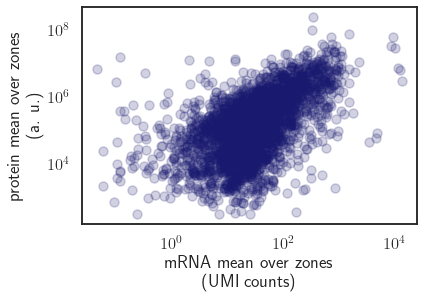

In [10]:
plt.scatter(mean_df['M_mean_scaled'], mean_df['P_mean_scaled'], alpha=0.2, color='midnightblue')
plt.xscale('log')
plt.xlabel('mRNA mean over zones\n(UMI counts)')
plt.yscale('log')
plt.ylabel('protein mean over zones\n (a. u.)')

#### B) Filtering results by model fitness (posterior predictive p-value) and relative size of confidence intervals on $\beta$ and $\delta$

In [31]:
# only results which have posterior predictive p-value>0.05
pthr = 0.05
cond1 = (results_df['pp_pval'] >= pthr)

# only results for which the beta and delta estimates are constrained
factor = 4

cond2a = (results_df['beta_HDI68_right']/results_df['beta_mode'] < factor)
cond2b = (results_df['beta_mode']/results_df['beta_HDI68_left'] < factor)

cond3a = (results_df['delta_HDI68_right']/results_df['delta_mode'] < factor)
cond3b = (results_df['delta_mode']/results_df['delta_HDI68_left'] < factor)

# subset data
filter_df = results_df[cond1 & cond2a & cond2b & cond3a & cond3b].copy()

In [32]:
# add results of filtering steps to results_Df for later export
results_df['filter1_pval>0.05'] = cond1
results_df['filter2_confidence_intervals<4fold'] = (cond2a & cond2b & cond3a & cond3b)
results_df['filter_passed_both'] = (cond1 & cond2a & cond2b & cond3a & cond3b)

In [33]:
#filter_df.to_csv('extracted_results/filtered_results_pval0_05_CI4fold_96hours_Schwanhaeusser_prior.csv')

In [34]:
print('n genes pre-filtering:', len(results_df))
print('   pass p-val test:', len(results_df[cond1]))
print('   pass confidence interval width for beta test:', len(results_df[cond2a & cond2b]))
print('   pass confidence interval width for delta test:', len(results_df[cond3a & cond3b]))
print('      pass all tests:', len(filter_df))

n genes pre-filtering: 2866
   pass p-val test: 2401
   pass confidence interval width for beta test: 2016
   pass confidence interval width for delta test: 2798
      pass all tests: 1727


#### C) Comparison to Hansson values

In [35]:
# import Hansson data
hansson_df = pd.read_excel('external_data/Hansson_protein_lifetime.xlsx', index_col=0, header=0)
hansson_df.columns = ['Hansson half life (days)']

In [36]:
# remove duplicates from hansson index
hansson_df = hansson_df.groupby(hansson_df.index).mean()

In [37]:
hansson_df['Hansson half life (hours)'] = hansson_df['Hansson half life (days)'] * 24

In [38]:
# extract genes which appear in both dfs
hansson_double_genes = [x for x in filter_df.index if x in hansson_df.index]

In [39]:
len(hansson_double_genes)

1177

In [40]:
hansson_combi = pd.concat([filter_df.loc[hansson_double_genes], hansson_df.loc[hansson_double_genes]], axis=1)

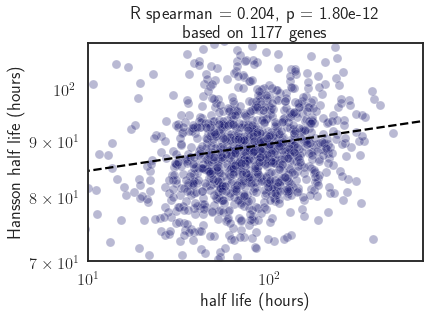

In [41]:
sns.scatterplot(x='half life (hours)', y='Hansson half life (hours)',
                data=hansson_combi, alpha=0.3, color='midnightblue')
plt.xlim((10, 700))
plt.xscale('log')
plt.ylim(bottom=70, top=110)
plt.yscale('log')
Rspear = spearmanr(hansson_combi['half life (hours)'], hansson_combi['Hansson half life (hours)'])
plt.title('R spearman = {}, p = {:.2e}\n based on {} genes'.format(np.round(Rspear[0], 3), Rspear[1], len(hansson_combi)))

# get linear regression line on log values
res_hansson = linregress(np.log(hansson_combi['half life (hours)']), np.log(hansson_combi['Hansson half life (hours)']))
xvals = np.linspace(1, 1000, 10)
plt.plot(xvals, np.exp(res_hansson.intercept)*(xvals**res_hansson.slope), '--', color='black')

plt.savefig('validation_figures/Hansson_correlation.pdf', bbox_inches='tight')

#### D) Comparison to Schwanhäusser values

In [42]:
schwan_df = pd.read_excel('external_data/Schwanhaeusser_simple.xlsx', index_col=0, header=0)

In [43]:
# the index of the schwanhäusser data needs to be cleaned up first
# for each gene in results_df, find the partnering schwanhäusser name
# and write it to dict as schwan: our name
schwan_dict = {}
for gene in results_df.index:
    for schwan in schwan_df.index:
        write=False
        try:
            if gene in schwan.split(';'):
                write=True
                break
        except AttributeError: # for skipping schwanhäusser empty lines
            pass
    if write:
        schwan_dict[schwan] = gene

In [44]:
# use the dict to rename the Schwan data
new_index = [schwan_dict[x] if x in schwan_dict.keys() else x for x in schwan_df.index]

In [45]:
schwan_df.index = new_index

In [46]:
# remove duplicates from schwan index
schwan_df = schwan_df.groupby(schwan_df.index).mean()

In [47]:
# extract genes which appear in both dfs
schwan_double_genes = [x for x in filter_df.index if x in schwan_df.index]

In [48]:
len(schwan_double_genes)

1288

In [49]:
schwan_combi = pd.concat([filter_df.loc[schwan_double_genes],
                          schwan_df.loc[schwan_double_genes]], axis=1)

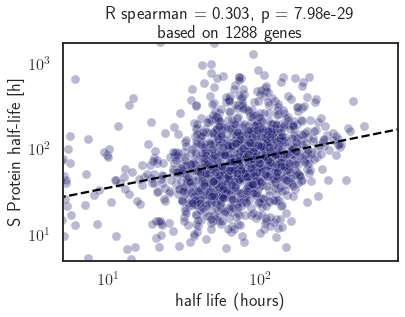

In [50]:
sns.scatterplot(x='half life (hours)', y='S Protein half-life [h]',
                data=schwan_combi, alpha=0.3, color='midnightblue')
plt.xlim((5, 800))
plt.xscale('log')
plt.ylim((5, 1700))
plt.yscale('log')

plt.title('R spearman = {}'.format(spearmanr(schwan_combi['half life (hours)'],
                                            schwan_combi['S Protein half-life [h]'])))
Rspear = spearmanr(schwan_combi['half life (hours)'], schwan_combi['S Protein half-life [h]'])
plt.title('R spearman = {}, p = {:.2e}\n based on {} genes'.format(np.round(Rspear[0], 3), Rspear[1], len(schwan_combi)))

# get linear regression line on log values
res_schwan = linregress(np.log(schwan_combi['half life (hours)']), np.log(schwan_combi['S Protein half-life [h]']))
xvals = np.linspace(1, 10000, 10)
plt.plot(xvals, np.exp(res_schwan.intercept)*(xvals**res_schwan.slope), '--', color='black')

plt.savefig('validation_figures/Schwanhausser_correlation.pdf', bbox_inches='tight')

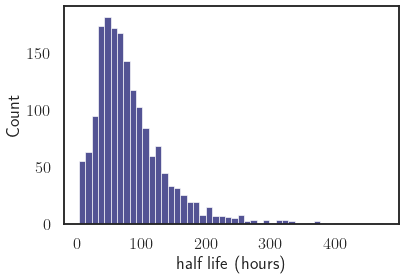

In [51]:
sns.histplot(data=filter_df, x='half life (hours)', color='midnightblue')
#plt.xlim((0, 300))
plt.savefig('validation_figures/half_life_hist_Itzkovitz.pdf', bbox_inches='tight')

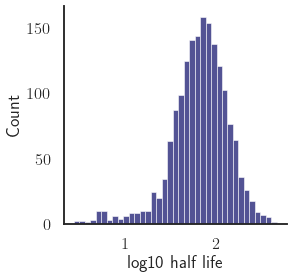

In [52]:
plt.figure(figsize=(4,4))
filter_df['log10 half life'] = np.log10(filter_df['half life (hours)'])
sns.histplot(data=filter_df, x='log10 half life', color='midnightblue')
#plt.xlim((0, 300))
sns.despine()
plt.savefig('validation_figures/log_half_life_hist_Itzkovitz.pdf', bbox_inches='tight')

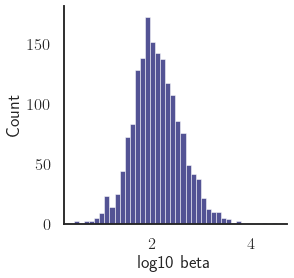

In [53]:
plt.figure(figsize=(4,4))
filter_df['log10 beta'] = np.log10(filter_df['beta_mode'])
sns.histplot(data=filter_df, x='log10 beta', color='midnightblue')
#plt.xlim((0, 300))
sns.despine()
plt.savefig('validation_figures/log_beta_hist_Itzkovitz.pdf', bbox_inches='tight')

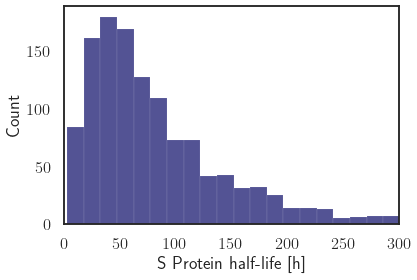

In [54]:
sns.histplot(data=schwan_combi, x='S Protein half-life [h]', color='midnightblue')
plt.xlim((0, 300))
plt.savefig('validation_figures/half_life_hist_Schwanhausser.pdf', bbox_inches='tight')

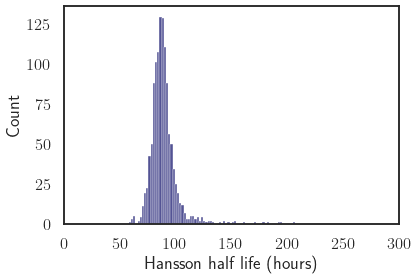

In [55]:
sns.histplot(data=hansson_combi, x='Hansson half life (hours)', color='midnightblue')
plt.xlim((0, 300))
plt.savefig('validation_figures/half_life_hist_Hansson.pdf', bbox_inches='tight')

In [64]:
schwan_combi['b_d_ratio'] = schwan_combi['beta_mode']/schwan_combi['delta_mode']
schwan_combi['S b_d_ratio'] = schwan_combi['S translation rate constant [molecules/(mRNA*h)]']/(np.log(2)/schwan_combi['S Protein half-life [h]'])

In [65]:
# drop nan from Schwanhäusser translation rates
schwan_combi_B = schwan_combi.dropna(subset=['S translation rate constant [molecules/(mRNA*h)]']).copy()

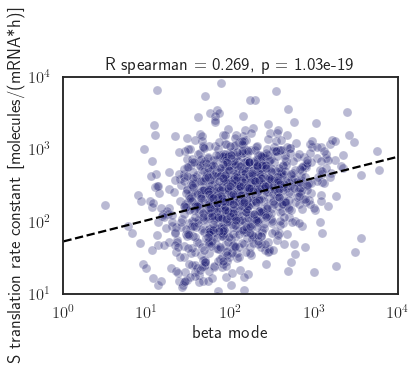

In [66]:
# rename for latex
schwan_combi_B['beta mode'] = schwan_combi_B['beta_mode']
sns.scatterplot(x='beta mode', y='S translation rate constant [molecules/(mRNA*h)]',
               data=schwan_combi_B, alpha=0.3, color='midnightblue')
plt.xlim((1e0, 1e4))
plt.xscale('log')
plt.ylim((1e1, 1e4))
plt.yscale('log')
plt.xscale('log')

Rspear = spearmanr(schwan_combi_B['beta mode'],
                   schwan_combi_B['S translation rate constant [molecules/(mRNA*h)]'],
                   nan_policy='omit')
plt.title('R spearman = {}, p = {:.2e}'.format(np.round(Rspear[0], 3), Rspear[1]))

# get linear regression line on log values
res_schwan = linregress(np.log(schwan_combi_B['beta mode']), np.log(schwan_combi_B['S translation rate constant [molecules/(mRNA*h)]']))
xvals = np.linspace(1, 10000, 10)
plt.plot(xvals, np.exp(res_schwan.intercept)*(xvals**res_schwan.slope), '--', color='black')

plt.savefig('validation_figures/Schwan_beta_correlation.pdf', bbox_inches='tight')

In [67]:
len(schwan_combi['S translation rate constant [molecules/(mRNA*h)]'].dropna())

1102

#### E) Comparison to translation efficiency data

In [69]:
# import translation efficiency data
te_df = pd.read_csv('external_data/te_table.tsv', index_col=2, header=0, sep='\t')
te_df.drop(['target_id', 'ens_gene'], axis=1, inplace=True)

In [70]:
# the dataset contains fasted and fed mice, for better comparability use fed below
fast_mean = te_df[['te_fast1', 'te_fast2', 'te_fast3']].mean(axis=1)
fed_mean = te_df[['te_refed1', 'te_refed2', 'te_refed3']].mean(axis=1)
# dict of the two series
te_dict= {'TE_fasted': fast_mean, 'TE_refed': fed_mean}
te_mean_df = pd.concat(te_dict, axis=1)

In [71]:
# remove duplicates from schwan index
te_mean_df = te_mean_df.groupby(te_mean_df.index).mean()

In [72]:
# extract genes which appear in both dfs
te_double_genes = [x for x in filter_df.index if x in te_mean_df.index]

In [73]:
len(te_double_genes)

1358

In [74]:
te_combi = pd.concat([filter_df.loc[te_double_genes],
                          te_mean_df.loc[te_double_genes]], axis=1)

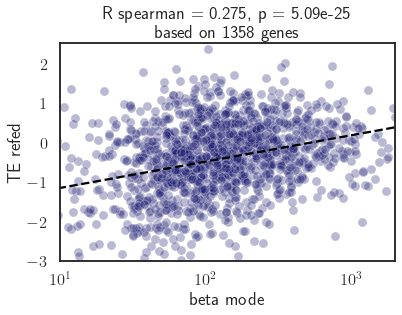

In [75]:
# rename because of latex issues
te_combi['beta mode'] = te_combi['beta_mode']
te_combi['TE refed'] = te_combi['TE_refed']
sns.scatterplot(x='beta mode', y='TE refed',
                data=te_combi, alpha=0.3, color='midnightblue')
# plt.plot(np.logspace(-2, 3, 100), np.logspace(-2, 3, 100), '-k')
plt.xlim((10, 2000))
plt.xscale('log')
plt.ylim((-3, 2.5))


Rspear = spearmanr(te_combi['beta_mode'], te_combi['TE refed'])
plt.title('R spearman = {}, p = {:.2e}\n based on {} genes'.format(np.round(Rspear[0], 3), Rspear[1], len(te_combi)))

# get linear regression line on log values
res_te = linregress(np.log(te_combi['beta mode']), te_combi['TE refed'])
xvals = np.linspace(1, 10000, 10)
plt.plot(xvals, res_te.intercept +np.log(xvals)*res_te.slope, '--', color='black')

plt.savefig('validation_figures/TE_refed_beta_correlation.pdf', bbox_inches='tight')

In [76]:
results_df.columns

Index(['beta_HDI68_left', 'beta_HDI68_right', 'beta_HDI95_left',
       'beta_HDI95_right', 'beta_mode', 'beta_p16', 'beta_p50', 'beta_p84',
       'delta_HDI68_left', 'delta_HDI68_right', 'delta_HDI95_left',
       'delta_HDI95_right', 'delta_mode', 'delta_p16', 'delta_p50',
       'delta_p84', 'model_HDI0.68_left_tp1', 'model_HDI0.68_left_tp2',
       'model_HDI0.68_left_tp3', 'model_HDI0.68_left_tp4',
       'model_HDI0.68_left_tp5', 'model_HDI0.68_left_tp6',
       'model_HDI0.68_right_tp1', 'model_HDI0.68_right_tp2',
       'model_HDI0.68_right_tp3', 'model_HDI0.68_right_tp4',
       'model_HDI0.68_right_tp5', 'model_HDI0.68_right_tp6',
       'model_HDI0.95_left_tp1', 'model_HDI0.95_left_tp2',
       'model_HDI0.95_left_tp3', 'model_HDI0.95_left_tp4',
       'model_HDI0.95_left_tp5', 'model_HDI0.95_left_tp6',
       'model_HDI0.95_right_tp1', 'model_HDI0.95_right_tp2',
       'model_HDI0.95_right_tp3', 'model_HDI0.95_right_tp4',
       'model_HDI0.95_right_tp5', 'model_HDI0.95_ri

#### F) data export of main profiles and fit results (for table S3)

In [78]:
# collect mRNA, protein, protein_sem profiles and mean versions of them
M_data_meannorm = M_data.divide(M_data.mean(axis=1), axis=0).copy()
P_data_meannorm = P_data.divide(P_data.mean(axis=1), axis=0).copy()
Psem_data_meannorm = Psem_data.divide(P_data.mean(axis=1), axis=0).copy()

data_coll = [M_data, P_data, Psem_data, M_data_meannorm, P_data_meannorm, Psem_data_meannorm]
# column names for all dataframes need to be changed before concat
col_prefix = ['mRNA (scaled to molecules/cell), ',
              'protein (scaled to molecules/cell), ',
              'protein SEM (scaled to molecules/cell), ',
              'mRNA (mean-normalized), ',
              'protein (mean-normalized), ',
              'protein SEM (mean-normalized), ']

renamed_dfs = []
for i, dataframe in enumerate(data_coll):
    new_names = [col_prefix[i] + name for name in dataframe.columns]
    df_copy = dataframe.copy()
    df_copy.columns = new_names
    renamed_dfs.append(df_copy)

# get model values from results_df

model_column_names = [x for x in results_df.columns if x.startswith('protein model MAP')]
filter_column_names = [x for x in results_df.columns if x.startswith('filter')]

model_df = results_df[model_column_names + ['beta_mode', 'delta_mode', 'half life (hours)',
                                            'beta_HDI68_left', 'beta_HDI68_right',
                                            'delta_HDI68_left', 'delta_HDI95_right']
                      + filter_column_names].copy()
# rename columns to include units
model_df.columns = model_column_names + ['beta MAP (proteins/(mRNA*hour))',
                                         'delta MAP (1/hour)', 'half life MAP (hours)',
                                         'beta HDI68 lower bound (proteins/(mRNA*hour))',
                                         'beta HDI68 upper bound (proteins/(mRNA*hour))',
                                         'delta HDI68 lower bound (1/hour)',
                                         'delta HDI68 upper bound (1/hour)'] + filter_column_names


renamed_dfs.append(model_df)

exp_data_df = pd.concat(renamed_dfs, axis=1)

# export!
exp_data_df.to_csv('extracted_results/combined_data_and_model_profiles_fit_results.csv')

In [79]:
exp_data_df

,"mRNA (scaled to molecules/cell), V1","mRNA (scaled to molecules/cell), V2","mRNA (scaled to molecules/cell), V3","mRNA (scaled to molecules/cell), V4","mRNA (scaled to molecules/cell), V5","mRNA (scaled to molecules/cell), V6","protein (scaled to molecules/cell), V1","protein (scaled to molecules/cell), V2","protein (scaled to molecules/cell), V3","protein (scaled to molecules/cell), V4",...,beta MAP (proteins/(mRNA*hour)),delta MAP (1/hour),half life MAP (hours),beta HDI68 lower bound (proteins/(mRNA*hour)),beta HDI68 upper bound (proteins/(mRNA*hour)),delta HDI68 lower bound (1/hour),delta HDI68 upper bound (1/hour),filter1_pval>0.05,filter2_confidence_intervals<4fold,filter_passed_both
gene,,,,,,,,,,,,,,,,,,,,,
A1cf,30.632564,26.819883,27.504519,19.073647,10.575900,7.674872,83752.184305,6.736429e+04,1.107331e+05,6.423956e+04,...,60.824318,0.009355,74.094163,24.083275,101.131188,0.003997,0.026444,True,True,True
Aadac,120.809324,94.628644,43.757190,26.158144,8.948839,2.951874,275098.537906,1.050424e+06,1.132347e+06,1.213319e+06,...,274.992960,0.006355,109.067771,208.134385,354.483826,0.004937,0.009377,True,True,True
Aak1,23.748842,20.241421,25.004108,14.986437,8.542073,4.132623,23233.277204,2.303256e+04,2.068371e+04,3.220575e+04,...,18.449203,0.004444,155.962364,12.570153,21.681510,0.002136,0.010840,True,True,True
Aamdc,215.804690,196.341785,166.277321,95.640715,36.608886,9.445997,159659.342276,3.522614e+05,3.262323e+05,3.610011e+05,...,55.487775,0.004137,167.550116,25.664062,117.947153,0.002419,0.010311,True,True,True
Aars,27.190703,12.650888,7.501233,7.356978,3.660889,4.132623,191894.833202,2.040383e+05,1.724498e+05,1.637626e+05,...,132.524767,0.011455,60.509159,29.443128,259.221700,0.004401,0.025428,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmpste24,24.093028,14.168995,15.002465,6.539536,4.067654,1.180750,57512.669828,1.242431e+05,1.252007e+05,1.544838e+05,...,104.836491,0.009637,71.923513,46.620062,144.490281,0.004637,0.019271,True,True,True
Znhit6,2.065117,0.000000,0.000000,0.272481,0.000000,0.000000,6176.745518,0.000000e+00,6.480158e+03,7.794314e+03,...,95.740306,0.005379,128.867890,22.235291,363.736271,0.002699,0.017202,True,False,False
Zw10,6.883722,7.084497,3.750616,4.359691,4.881185,0.590375,14456.769035,1.445860e+04,1.002593e+04,1.737506e+04,...,61.793858,0.007964,87.034882,29.136045,160.564489,0.003521,0.027756,True,True,True
